<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/OpenCV/OpenCvLineExtraction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Line extraction using openCV

Libraries import



In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Useful function to plot images in notebooks

In [ ]:
def imshow(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()

Loading the image as a frame of the gif

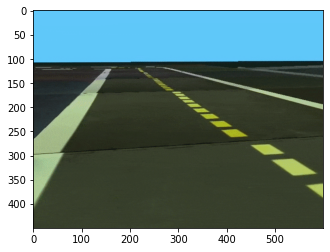

In [ ]:
SELECTED_FRAME = 160

cap = cv2.VideoCapture('./video1.gif')

cap.set(cv2.CAP_PROP_POS_FRAMES, SELECTED_FRAME)

ret, frame = cap.read()

imshow(frame)

Selecting the Red and Saturation channels

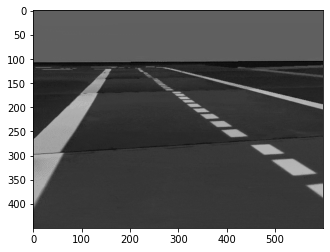

In [ ]:
R = frame[:,:,2]
imshow(R)

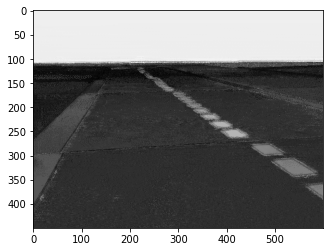

In [ ]:
hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
S = hls_frame[:, :, 2]
imshow(S)

Thresholding the results

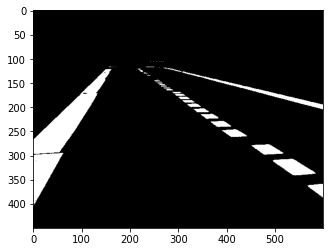

In [ ]:
R_THRESH = 127
ret, trR = cv2.threshold(R, R_THRESH, 255, cv2.THRESH_BINARY)
imshow(trR)

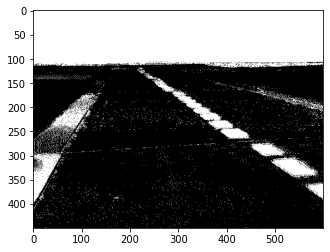

In [ ]:
S_THRESH = 70
ret, trS = cv2.threshold(S, S_THRESH, 255, cv2.THRESH_BINARY)
imshow(trS)

Bitwise AND between the thresholded channels

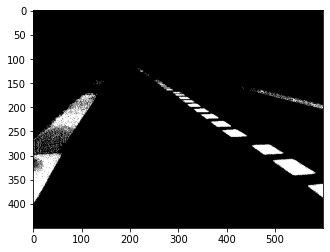

In [ ]:
trRS = cv2.bitwise_and(trR, trS)
imshow(trRS)

Bird eye view generation

Source and Destination points

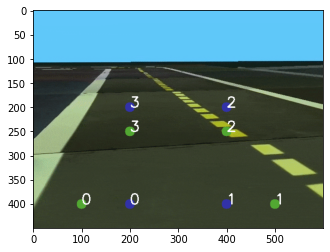

In [ ]:
Src = np.float32([
    [100, 400],
    [500, 400],
    [400, 250],
    [200, 250],
])

Dst = np.float32([
    [200, 400],
    [400, 400],
    [400, 200],
    [200, 200]
])

SRC_COLOR = (50, 168, 82)
DST_COLOR = (168, 50, 50)

CIRCLE_RADIUS = 10

FONT_SIZE = 1
TEXT_COLOR = (255, 255, 255)
FONT_THICK = 2

disp = frame.copy()

for i, s in enumerate(Src):
    cv2.circle(disp, s.astype(int), CIRCLE_RADIUS, SRC_COLOR, -1)
    cv2.putText(disp, str(i), s.astype(int), cv2.FONT_HERSHEY_SIMPLEX, FONT_SIZE, TEXT_COLOR, FONT_THICK)

for i, d in enumerate(Dst):
    cv2.circle(disp, d.astype(int), CIRCLE_RADIUS, DST_COLOR, -1)
    cv2.putText(disp, str(i), d.astype(int), cv2.FONT_HERSHEY_SIMPLEX, FONT_SIZE, TEXT_COLOR, FONT_THICK)

imshow(disp)

Computes the bird eye view transform

In [ ]:
M = cv2.getPerspectiveTransform(Src, Dst)
print(M)

[[-1.5e+00 -3.0e+00  7.5e+02]
 [ 0.0e+00 -6.0e+00  1.2e+03]
 [-0.0e+00 -1.0e-02  1.0e+00]]


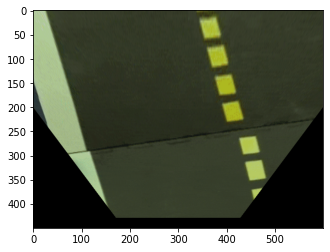

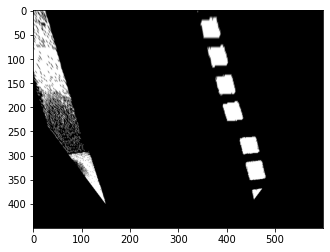

In [ ]:
rows, cols, chan = frame.shape

BE_frame = cv2.warpPerspective(frame, M, (cols, rows))
imshow(BE_frame)

BE_trRS = cv2.warpPerspective(trRS, M, (cols, rows))
imshow(BE_trRS)

Vertical histogram of the lowest half of the image

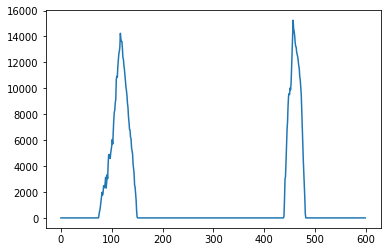

In [ ]:
hist = np.sum(BE_trRS[cols//2:, :], axis=0)

plt.plot(hist)
plt.show()

Sliding windows

Finding the base of the windows as the arg max of the left and right size of the histogram

In [ ]:
midpoint = frame.shape[1] // 2

l_base = np.argmax(hist[:midpoint])
r_base = midpoint + np.argmax(hist[midpoint:])

print(l_base, r_base)

117 457


Setting up windows parameters

In [ ]:
N_WINS = 9
WIDTH_RAD = 50
MIN_PIX_FRACT = .01

win_height = (BE_trRS.shape[0]-1)//N_WINS

min_pix = 2*WIDTH_RAD*win_height*MIN_PIX_FRACT

Sliding windows main function

baseX - the starting x position of the first sliding window

outIndices - a list that will be populated with the coordinates of the selcted white pixels

disp - an image where to draw the sliding windows rectangles

In [ ]:
from types import NoneType


def slidingWins(baseX, outIndices, disp = None):
    curr_x = baseX
    curr_y = rows - 1

    for _ in range(N_WINS):
        selectedImage = BE_trRS[
            curr_y - win_height: curr_y,
            max(curr_x - WIDTH_RAD, 0) : min(curr_x + WIDTH_RAD, cols-1),
        ]

        if(type(disp) != NoneType):
            cv2.rectangle(disp,
                (max(curr_x - WIDTH_RAD, 0), curr_y - win_height),
                (min(curr_x + WIDTH_RAD, cols-1), curr_y),
                (255, 255, 255),
                4
            )

        localNonZero = np.array(selectedImage.nonzero())

        for i, a in enumerate(localNonZero[1]):
            localNonZero[1][i] += curr_x - WIDTH_RAD

        for i, a in enumerate(localNonZero[0]):
            localNonZero[0][i] += curr_y - win_height

        lnzXs = localNonZero[1]
        if len(lnzXs) > min_pix:
            curr_x = sum(lnzXs) // len(lnzXs)

        outIndices[0] += localNonZero.tolist()[0]
        outIndices[1] += localNonZero.tolist()[1]

        curr_y -= win_height

Finds the indices of the selected pixels in the left and right half of the image 

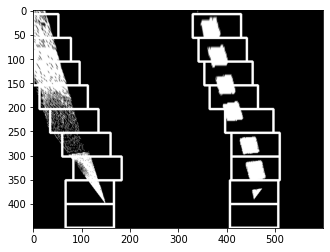

In [ ]:
disp = BE_trRS.copy()

l_indices = [[], []]
slidingWins(l_base, l_indices, disp)

r_indices = [[], []]
slidingWins(r_base, r_indices, disp)

imshow(disp)


Polinomial fit

In [ ]:
def p(x, coef):
    res = 0
    for c in coef:
        res *= x
        res += c
    return res

In [ ]:
POL_DEG = 2

l_coef = np.polyfit(l_indices[1], l_indices[0], POL_DEG)
r_coef = np.polyfit(r_indices[1], r_indices[0], POL_DEG)

In [ ]:
def DrawPol(coef, disp, data, color = (255, 255, 255)):
    minX = np.min(data[1])
    maxX = np.max(data[1])

    minY = np.min(data[0])
    maxY = np.max(data[0])

    points = []

    for x in range(minX, maxX+1):
        y = int(p(x, coef))

        if(minY <= y <= maxY):
            points.append([x, y])


    if len(points) > 0:
        points = np.array(points, np.int32)
        points.reshape((-1, 1, 2))
        cv2.polylines(disp, [points], False, color, 20)

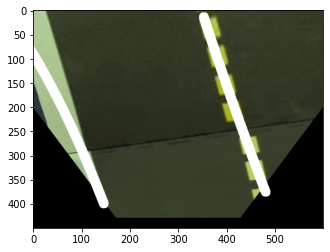

In [ ]:
disp = BE_frame.copy()

DrawPol(l_coef, disp, l_indices)
DrawPol(r_coef, disp, r_indices)


imshow(disp)